In [1]:
#Feature Importance
#cont10, cont9, cont12, cont7, cont5, cont2, cat1, cont3, cont0, cont13, cont4, cont11, cat8, cont6, cont1

#cat1, cat8
# Modules

#plotting
import seaborn
import matplotlib.pyplot as plt

#Number processing
import numpy as np
from scipy import sparse

#Data frame
import pandas as pd

#Cross Validation
from sklearn import model_selection

#ordinal encoding categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Trees
from sklearn import tree
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

#Statistics/Feature Engineering
from scipy.stats import boxcox

#Normalization and Standardization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#garbage collection
import gc

#Pipeline and prevent data leakage in hyperparameter tuning section
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from skopt import BayesSearchCV

from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings("ignore")

In [2]:
filepath1 = 'C:\\Users\\Andrew\\Machine Learning Python\\Comp1\\train.csv' 
filepath2 = 'C:\\Users\\Andrew\\Machine Learning Python\\Comp1\\test.csv'

#alternate
# filepath1 = '../input/30daysml/train.csv' 
# filepath2 = '../input/30daysml/test.csv'


## Loading data and obtaining column names

In [3]:
def new_run(filepath1, filepath2): #use this function to for first start, or to refresh train_data and test_data
    train_data = pd.read_csv(filepath1)
    test_data = pd.read_csv(filepath2)
    
    return train_data, test_data

def func_categorical_data(train_data):
    categorical_cols = train_data.columns[1:11]
    
    return categorical_cols

def func_cont_data(train_data):
    cont_cols = train_data.columns[11:-1]
    
    return cont_cols


    
train_data, test_data = new_run(filepath1, filepath2)    
    
categorical_cols = func_categorical_data(train_data)
# for pandas data frame: the below means the same thing 
# train_data.target is train_data['target'] ---> True

cont_cols = func_cont_data(train_data)
y_train_targets = train_data.target

# cat1    cont0    cont2    cont3    cont4   cont6   cont7    cont10    cont11    cont12    cont13

## Run below sampler code for hypertuning, (to increase speed by reducing data size)

In [7]:
train_data = train_data.sample(frac = 0.3) #
test_data = test_data.sample(frac = 0.3)

In [8]:
train_data.shape

(90000, 26)

In [219]:
#variables
#(train_data, test_data, categorical_cols, cont_cols, clean_cols, y_train_targets)

## Categorical Encoding

In [9]:
class EncodingCategoricalObj(): 
    def __init__(self, train_data, test_data, ordinal_enc_cols = [], onehot_enc_cols = [], label_enc_cols = []):
        # selected columns, create encoding () object and specify which encoder you want

        #initialize object, specifying the categorical columns for each encoder
        self.train_data = train_data
        self.test_data = test_data
        
        #Note: make sure the data type is acceptable 
        self.ordinal_enc_cols = ordinal_enc_cols
        self.onehot_enc_cols = onehot_enc_cols
        self.label_enc_cols = label_enc_cols
        
    # class functions for each encoder
    
    # since the categorical data varies (some only have 1-3 values, while a few columns have >6 values)
    # since for each encoder, fit_tranform and transform only affects train_data[selected_cols], we can have multiple encoders
    # on the dataframe
    def ordinal_Encoder(self):
        for ordinal_col in self.ordinal_enc_cols:
            my_ordinal_encoder = OrdinalEncoder()
            #ordinal encoding numpy array -> reshape (-1, 1) -> b/c expecting 2d array, gave 1d array when just passing column
            self.train_data[ordinal_col] = my_ordinal_encoder.fit_transform(self.train_data[ordinal_col].to_numpy().reshape(-1, 1))
            self.test_data[ordinal_col] = my_ordinal_encoder.transform(self.test_data[ordinal_col].to_numpy().reshape(-1, 1))
    
    def oneHot_Encoder(self):
        
        one_hot_temp_df = pd.get_dummies(self.train_data[self.onehot_enc_cols], prefix = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'])
        self.train_data = self.train_data.drop(self.onehot_enc_cols, axis = 1)
        self.train_data = self.train_data.join(one_hot_temp_df)
        
        one_hot_temp_df = pd.get_dummies(self.test_data[self.onehot_enc_cols], prefix = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'])
        self.test_data = self.test_data.drop(self.onehot_enc_cols, axis = 1)
        self.test_data = self.test_data.join(one_hot_temp_df)
        

    def label_Encoder(self):
        for label_col in self.label_enc_cols:
            my_label_encoder = LabelEncoder()
            self.train_data[label_col] = my_label_encoder.fit_transform(self.train_data[label_col])
            self.test_data[label_col] = my_label_encoder.transform(self.test_data[label_col])
        
    def main(self):
        if type(self.ordinal_enc_cols) == pd.core.indexes.base.Index or type(self.ordinal_enc_cols) == str:
            self.ordinal_Encoder()
        if type(self.onehot_enc_cols) == pd.core.indexes.base.Index or type(self.onehot_enc_cols) == str:
            self.oneHot_Encoder()
        if type(self.label_enc_cols) == pd.core.indexes.base.Index or type(self.label_enc_cols) == str:
            self.label_Encoder()

#Run the
#encodingCategoricalObj = EncodingCategoricalObj(train_data, test_data, onehot_enc_cols = categorical_cols)
encodingCategoricalObj = EncodingCategoricalObj(train_data, test_data, ordinal_enc_cols = categorical_cols)
encodingCategoricalObj.main()

train_data = encodingCategoricalObj.train_data
test_data = encodingCategoricalObj.test_data

In [10]:
del encodingCategoricalObj 
gc.collect()

10

In [14]:
train_data.cat0.value_counts()

0.0    57865
1.0    32135
Name: cat0, dtype: int64

In [15]:
train_data.cat1.value_counts()

0.0    46395
1.0    43605
Name: cat1, dtype: int64

## Feature Selection

In [61]:
import pdb
# selectedFeatureListCont = ['cont10', 'cont9', 'cont12', 'cont7', 'cont5', 'cont2', 'cont6',
#                            'cont3', 'cont0', 'cont13', 'cont4', 'cont11', 'cont1']
selectedFeatureListCont = ['cont0', 'cont1', 'cont2', 'cont3']
# selectedFeatureListCat = ['cat1', 'cat8']
selectedFeatureListCat = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

## for drop use columns = 

class FeatureSelection():#right now, just drop everything except selected features
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
    
    def drop_(self, selectedFeatureListCont, selectedFeatureListCat):
        temp_train, temp_test = self.train_data.copy(), self.test_data.copy()
#         temp_train2, temp_test2 = self.train_data.copy(), self.test_data.copy()
        cont_train = temp_train[selectedFeatureListCont]
        cont_test = temp_test[selectedFeatureListCont]

        cat_train = temp_train[selectedFeatureListCat]
        cat_test = temp_test[selectedFeatureListCat]
        #print(cat_test)
        self.train_data = pd.concat((self.train_data['id'], pd.DataFrame(cont_train), pd.DataFrame(cat_train), self.train_data['target']), axis = 1)
        self.test_data = pd.concat((self.test_data['id'], pd.DataFrame(cont_test), pd.DataFrame(cat_test)), axis = 1)
        #db.set_trace()
featureSelection = FeatureSelection(train_data, test_data)        
#cont_cols = [i for i in featureSelection.train_data.columns if i.startswith('cont')]
featureSelection.drop_(selectedFeatureListCont, selectedFeatureListCat)
train_data = featureSelection.train_data
test_data = featureSelection.test_data

cont_cols = selectedFeatureListCont 

In [88]:
del featureSelection
gc.collect()

NameError: name 'featureSelection' is not defined

## Feature Engineering Class (only encode within cross-validation step)
## BUT ALSO ENCODE TEST DATA BEFORE ANYTHING

In [21]:
import pdb
class EncodingContinuousObj(): 
    def __init__(self, train_data, test_data, stand_enc_cols = None, squarert_enc_cols = None, log_enc_cols = None, recp_enc_cols = None):
        
        self.train_data = train_data
        self.test_data = test_data
                
        self.stand_enc_cols = stand_enc_cols
        
        self.squarert_enc_cols = squarert_enc_cols
        self.log_enc_cols = log_enc_cols
        self.recp_enc_cols = recp_enc_cols
        
        self.squareroot_train = None
        self.log1_train = None
        self.reciprical_train = None
        
        self.squareroot_test = None
        self.log1_test = None
        self.reciprical_test = None
    
    ## Normalization or Standardization
    # Only encode during cross-validation to avoid data leakage
    def normalEncoder(self, train_data, test_data, cont_cols):
        cvtrain, cvtest = train_data, test_data #.copy() not needed, function cannot change global scope
        for col in cont_cols:
            
            train_numpy = cvtrain[col].to_numpy().reshape(-1, 1) 

            test_numpy = cvtest[col].to_numpy().reshape(-1, 1) 

            my_normalizer = MinMaxScaler()
            train_numpy = my_normalizer.fit_transform(train_numpy)
            test_numpy = my_normalizer.fit_transform(test_numpy)
#             print(train_numpy)
#             print(test_numpy)

            cvtrain[col] = train_numpy
            cvtest[col] = test_numpy
        return cvtrain, cvtest    
            
        #self.cvtrain = pd.DataFrame(self.cvtrain)
        #self.cvtest = pd.DataFrame(self.cvtest)
        
    # Standardization uses sd, mean, and assumes normal distribution
    # from the graph, cont4 is obviously skewed, so we will drop it for now
    def standardEncoder(self, train_data, test_data, cont_cols):
        
        cvtrain, cvtest = train_data, test_data
        for col in cont_cols:
            
            train_numpy = cvtrain[col].to_numpy().reshape(-1, 1) 

            test_numpy = cvtest[col].to_numpy().reshape(-1, 1) 

            my_standardizer = StandardScaler()
            train_numpy = my_normalizer.fit_transform(train_numpy)
            test_numpy = my_normalizer.fit_transform(test_numpy)
#             print(train_numpy)
#             print(test_numpy)

            cvtrain[col] = train_numpy
            cvtest[col] = test_numpy
        return cvtrain, cvtest        
        #self.cvtrain = pd.DataFrame(self.cvtrain)
        #self.cvtest = pd.DataFrame(self.cvtest)
        

    def testEncoder(self): #scalar transformation right shift by 1e2 to remove zeros
        self.train_data[cont_cols] += 1e2
        self.test_data[cont_cols] += 1e2
    
    ########################################################################################
    # need debugging
    ###### For some reason, train_data and test data become numpy arrays in this section of the code
    
    
    ## Later want to implement this function as well into cross-validation
    def contTransformEncoder(self, stand_enc_cols = None, squarert_enc_cols = None, log_enc_cols = None, recp_enc_cols = None):  ### NOT WORKING RIGHT NOW
             
        ###
        ### IMPORTANT, for square root, there are negative values
        ### avoid cont0, cont1, cont2, cont6, cont8 which have negative values
        
        # ONLY FOR GAUSSIAN DATA
        if type(self.stand_enc_cols) == pd.core.indexes.base.Index or type(self.squarert_enc_cols) == str:
            my_normalizer = MinMaxScaler()
            self.train_data = my_normalizer.fit_transform(self.train_data[cont_cols])
            self.test_data = my_normalizer.fit_transform(self.test_data[cont_cols])
        
        if type(self.squarert_enc_cols) == pd.core.indexes.base.Index or type(self.squarert_enc_cols) == str:
            ### CHANGE TO IN-PLACE modification once sure everything working
            #train_data[self.squarert_enc_cols] = train_data[self.squarert_enc_cols]**0.5 
            #pdb.set_trace()
            self.squareroot_train = self.train_data[self.squarert_enc_cols]**0.5 
            self.squareroot_test = self.test_data[self.squarert_enc_cols]**0.5 
            
        # More debugging needed, log 0 error    
        if type(self.log_enc_cols) == pd.core.indexes.base.Index or type(self.log_enc_cols) == str:
            #train_data[self.squarert_enc_cols] = np.log(train_data[self.squarert_enc_cols])
            self.log1_train = np.log(self.train_data[self.log_enc_cols])
            self.log1_test = np.log(self.test_data[self.log_enc_cols])
            
        if type(self.recp_enc_cols) == pd.core.indexes.base.Index or type(self.recp_enc_cols) == str:
            #train_data[self.recp_enc_cols] = 1/(train_data[self.recp_enc_cols])
            self.reciprical_train = 1/(self.train_data[self.recp_enc_cols])
            self.reciprical_test = 1/(self.test_data[self.recp_enc_cols])


In [22]:
encodingContinuousObj = EncodingContinuousObj(train_data, test_data, stand_enc_cols = cont_cols, 
                                              squarert_enc_cols = cont_cols, log_enc_cols = cont_cols, 
                                              recp_enc_cols = cont_cols)

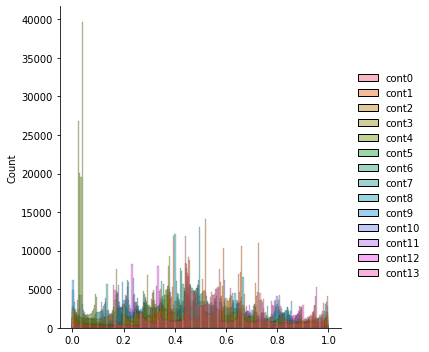

In [111]:
seaborn.displot(encodingContinuousObj.train_data[cont_cols])

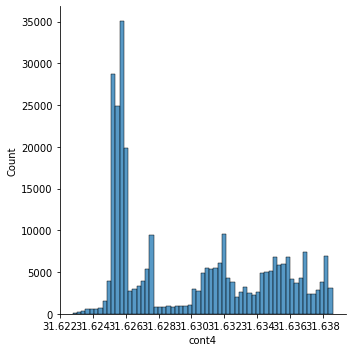

In [180]:
seaborn.displot(encodingContinuousObj.squareroot_train.cont4)

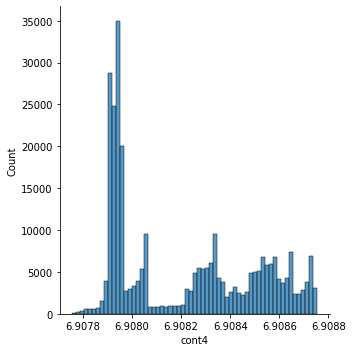

In [179]:
seaborn.displot(encodingContinuousObj.log1_train.cont4)

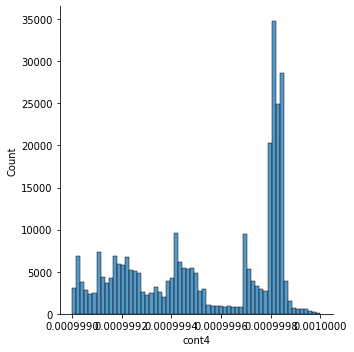

In [181]:
seaborn.displot(encodingContinuousObj.reciprical_train.cont4)

## K-Fold Cross-Validation

In [24]:
kfold_splits = 3
def kfold_cross_validation(kfold_splits):
    kf = model_selection.KFold(n_splits=kfold_splits, shuffle=True, random_state=0)
    return kf

kf = kfold_cross_validation(kfold_splits)

## Training the model (and now standardizing (to curb data leakage))

In [36]:
class TrainingModel(EncodingContinuousObj):
    
    def __init__ (self, train_data, test_data, y_train_targets, kf):
        self.train_data = train_data.drop(columns = ['id', 'target'])
        self.test_data = test_data.drop(columns = ['id']) #because test_data contains id column which we don't want
        self.y_train_targets = y_train_targets
        self.kf = kf

        
        ## crashes on local machine, run on kaggle
        self.predictions = [0, 0, 0, 0] #different predictions properties for each model
        self.scores = []
        
        ## Note: I copy pasted the main loop (for f, (ind1, ind2)...) 3 times. Clean up this code to avoid the copy pasting
        ## some wrappers have built in cv
        
        ## under other circumstances, inherited parent class should initialize here to get attributes
    
    def func_XGBRegressor(self):
        #### Standard Encoder, Normal Encoder implement into pipeline

        numerical_columns = [i for i in self.train_data.columns if i.startswith('cont')]
        cols_to_be_standardized = []
        cols_to_be_normalized = []

        numeric_transformer = Pipeline(steps = [('normal', MinMaxScaler())
                                               ]) #('normal', MinMaxScaler()), ('standard', StandardScaler())
        preprocessor = ColumnTransformer(transformers=
                                         [('num', MinMaxScaler(), numerical_columns)], 
                                         remainder='passthrough') #remainder passthrough to prevent dropping of columns , ('standard', StandardScaler(), numerical_columns)
        
        # from hotfix to now, processing test data from columntransformer right before cross validation loop
        self.test_data = preprocessor.fit_transform(self.test_data)
        ### 
        for f, (ind1, ind2) in enumerate(self.kf.split(self.train_data, y_train_targets)):
            xtrain, xvalid = self.train_data.iloc[ind1], self.train_data.iloc[ind2]

            ytrain, yvalid = self.y_train_targets[ind1], self.y_train_targets[ind2]   
            
            #Training
            #features selected -> model = xgb.XGBRegressor(n_estimators = 4000, learning_rate=0.025, random_state = 0, subsample = 0.66, min_child_weight = 0.1291, max_depth = 4, 
                                    #gamma = 4.12, colsample_bytree = 0.70, colsample_bylevel = 1.0,
                                    # tree_method='gpu_hist', gpu_id=0, predictor = "gpu_predictor",)
                    
            #{'subsample': 0.89, 'min_child_weight': 0.0771, 'max_depth': 3, 'learning_rate': 0.062, 
            #'gamma': 5.865, 'colsample_bytree': 0.8299999999999996, 'colsample_bylevel': 1.0}
            
            ######
            # with pipeline, with encoding
            #'xgbReg__subsample': 0.62, 'xgbReg__min_child_weight': 0.0251, 'xgbReg__max_depth': 8, 'xgbReg__learning_rate': 0.123, 
            #'xgbReg__gamma': 0.645, 'xgbReg__colsample_bytree': 0.19999999999999996, 'xgbReg__colsample_bylevel': 0.0
            
#             model = xgb.XGBRegressor(n_estimators = 2000, learning_rate=0.02, random_state = 0, subsample = 0.62, min_child_weight = 0.0251, max_depth = 8, 
#                                      gamma = 0.645, colsample_bytree = 0.199, colsample_bylevel = 0.0, 
#                                      tree_method='gpu_hist', gpu_id=0, predictor = "gpu_predictor", verbose = False)
            
            #####
            # increased parameter search size, pipeline with encoding, full features
#             {'xgbReg__subsample': 0.59, 'xgbReg__min_child_weight': 0.4231, 'xgbReg__max_depth': 8, 'xgbReg__learning_rate': 0.28150000000000003, 
#              'xgbReg__gamma': 1.25, 'xgbReg__colsample_bytree': 0.13999999999999999, 'xgbReg__colsample_bylevel': 0.0}
#             model = xgb.XGBRegressor(n_estimators = 2000, learning_rate=0.02, random_state = 0, subsample = 0.59, min_child_weight = 0.4231, max_depth = 8, 
#                                      gamma = 1.25, colsample_bytree = 0.14, colsample_bylevel = 0.0, 
#                                      tree_method='gpu_hist', gpu_id=0, predictor = "gpu_predictor", verbose = 0)
            
        
            ####
            # further improvements, pipeline with encoding, full features
#             {'xgbReg__subsample': 0.61, 'xgbReg__n_estimators': 200, 'xgbReg__min_child_weight': 0.0121, 'xgbReg__max_depth': 7, 
#              'xgbReg__learning_rate': 0.11950000000000001, 'xgbReg__gamma': 2.345, 'xgbReg__colsample_bytree': 0.20999999999999996, 'xgbReg__colsample_bylevel': 1.0}
            
            ####
            # best results from hint and tweaking
#             xgb_params = {'n_estimators': 10000,
#               'learning_rate': 0.20,
#               'subsample': 0.95,
#               'colsample_bytree': 0.9,
#               'max_depth': 2,  # tree depth
#               'reg_lambda': 35.0,
#               'reg_alpha': 35.0,
#               'random_state': 0,
#               'booster': 'gbtree',
#               'predictor': 'gpu_predictor',
#               'tree_method': 'gpu_hist'}
              
#                           # DO NOT USE GPU ID, KEEP VERBOSE FALSE 
            
            ####
            # Bayes Search CV results:
#OrderedDict([('xgbReg__colsample_bylevel', 0.8004730382612166), ('xgbReg__colsample_bytree', 0.8),
#('xgbReg__gamma', 1e-09), ('xgbReg__learning_rate', 0.0462845163395028), ('xgbReg__max_delta_step', 0), 
#('xgbReg__min_child_weight', 10.0), ('xgbReg__n_estimators', 6700), ('xgbReg__reg_alpha', 1.0095766678334039e-08),
#('xgbReg__reg_lambda', 1000.0), ('xgbReg__scale_pos_weight', 1e-05), ('xgbReg__subsample', 1.0)])
            
    
            #
            xgb_params = {'n_estimators': 10000, #tweaking 6700 -> 10000
                    'learning_rate': 0.046,
                    'subsample': 0.86,
                    'gamma':1e-09,
                    #'max_delta_step':0,
                    #'min_child_weight': 10.0,
                    'colsample_bytree': 0.95,
                    'max_depth': 2,  # tree depth
                    'reg_lambda': 500.0, #tweaking 1000 -> 500
                    #'reg_alpha': 1.009577e-08,
                    #'scale_pos_weight': 1e-05,
                    'random_state': 0,
                    'booster': 'gbtree',
                    'predictor': 'gpu_predictor',
                    'tree_method': 'gpu_hist'
              
                          # DO NOT USE GPU ID, KEEP VERBOSE FALSE 
                          # If GPU ID and VERBOSE TRUE, KAGGLE GPU/CPU will hang after 1 fold of K-fold CV
                              # need more testing to identify source of error
              }
            
            model = xgb.XGBRegressor(**xgb_params)
    
#             model = xgb.XGBRegressor(n_estimators = 10000, learning_rate = 0.08, subsample = 0.926,
#                                      max_depth = 2, colsample_bytree = 0.84, reg_lambda = 35, reg_alpha = 35,
#                                     booster = 'gbtree', gpu_id=0, predictor = "gpu_predictor", tree_method= 'gpu_hist',
#                                      random_state = 0, )
            
            xtrain = preprocessor.fit_transform(xtrain)
            xvalid = preprocessor.fit_transform(xvalid)
            
            
            pipe = Pipeline(steps= [('model', model)]) #('preprocessor', preprocessor)
                    # ('preprocessor', preprocessor), processing xtrain and xvalid INSIDE of sklearn Pipeline will give 
                    # feature not found error ie. "cont1, cont2, ... not found in training data"
                    # a lot of further research and testing needed to determine why this is the case
            eval_set = [(xtrain, ytrain), (xvalid, yvalid)] # difficulties in getting early stopping rounds to work
            
            pipe.fit(xtrain, ytrain, model__verbose = False, model__early_stopping_rounds = 300, model__eval_set = eval_set) 
            
            
            val_predictions = pipe.predict(xvalid)
            test_predictions = pipe.predict(self.test_data)
            self.predictions[0] += test_predictions * 0.10 # weight of 10 percent for 10 folds, 20 percent for 5 folds etc

            rmse = mean_squared_error(yvalid, val_predictions, squared = False)
            self.scores.append(rmse)
            print(f"{f} fold, rmse {rmse}")
            
            ## Feature Importance ##
#             feature_columns = self.train_data.columns
#             importances = model.feature_importances_
#             xgb_importances = np.array(list(zip(feature_columns, model.feature_importances_)))
            
            
        print(f"{np.mean(self.scores)} for XGBREG")
        print(self.scores)
        
            
            
    def func_XGBoost(self): # Not using for now, too similar to xgbregressor
        xgb_params= {
            "seed": 2000,
            'tree_method': "gpu_hist",
            "gpu_id": 0,
            'predictor': 'gpu_predictor'
        }
        for f, (ind1, ind2) in enumerate(self.kf.split(self.train_data, y_train_targets)):
            xtrain, xvalid = self.train_data.iloc[ind1], self.train_data.iloc[ind2]

            ytrain, yvalid = self.y_train_targets[ind1], self.y_train_targets[ind2]   
            
            #DMatrix
            xtrain = xgb.DMatrix(xtrain, label=ytrain)
            xvalid = xgb.DMatrix(xvalid, label=yvalid)
            
            model = xgb.train(xgb_params, xtrain, 1000)
            
            val_predictions = model.predict(xvalid)
            test_predictions = model.predict(self.test_data)
            self.predictions[1] += test_predictions * 0.10 # weight of 10 percent for 10 folds, 20 percent for 5 folds etc

            rmse = mean_squared_error(yvalid, val_predictions, squared = False)
            scores.append(rmse)
            print(f"{f} fold, rmse {rmse}")
        print(f"{np.mean(self.scores)} for XGBOOST")
        

    
    def func_RandomForestRegressor(self):
        numerical_columns = [i for i in self.train_data.columns if i.startswith('cont')]
        cols_to_be_standardized = []
        cols_to_be_normalized = []

        numeric_transformer = Pipeline(steps = [('normal', MinMaxScaler())
                                               ])
        preprocessor = ColumnTransformer(transformers=
                                         [('num', numeric_transformer, numerical_columns)
                                         ])
        
        for f, (ind1, ind2) in enumerate(self.kf.split(self.train_data, y_train_targets)):
            xtrain, xvalid = self.train_data.iloc[ind1], self.train_data.iloc[ind2]

            ytrain, yvalid = self.y_train_targets[ind1], self.y_train_targets[ind2]   
            

            model = RandomForestRegressor(n_estimators = 100, random_state = 0)
            
            
            pipe = Pipeline(steps= [('preprocessor', preprocessor), 
                                   ('model', model)])
            
            pipe.fit(xtrain, ytrain) #, early_stopping_rounds = 100, eval_set=[(xvalid, yvalid)], verbose = False
            


            val_predictions = pipe.predict(xvalid)
            test_predictions = pipe.predict(self.test_data)
            self.predictions[2] += test_predictions * 0.10 # weight of 10 percent for 10 folds, 20 percent for 5 folds etc

            rmse = mean_squared_error(yvalid, val_predictions, squared = False)
            scores.append(rmse)
            print(f"{f} fold, rmse {rmse}")
        print(f"{np.mean(self.scores)} for RANDOM FOREST")
    
    def func_LightLGBM(self): ## I haven't been installed the gpu version, tested cpu version on kaggle's kernel
        numerical_columns = [i for i in self.train_data.columns if i.startswith('cont')]
        cols_to_be_standardized = []
        cols_to_be_normalized = []

        numeric_transformer = Pipeline(steps = [('normal', MinMaxScaler())
                                               ])
        preprocessor = ColumnTransformer(transformers=
                                         [('num', numeric_transformer, numerical_columns)
                                         ])
        
        for f, (ind1, ind2) in enumerate(self.kf.split(self.train_data, y_train_targets)):
            xtrain, xvalid = self.train_data.iloc[ind1], self.train_data.iloc[ind2]

            ytrain, yvalid = self.y_train_targets[ind1], self.y_train_targets[ind2]   

            model = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=20, n_estimators=2000,
                                learning_rate=0.01, random_state = 0, reg_alpha = 0, reg_lambda = 5, min_child_samples = 500, min_child_weight = 0)
            
            pipe = Pipeline(steps= [('preprocessor', preprocessor), 
                                   ('model', model)])
            
            #'colsample_bytree': 1.0, 'min_child_samples': 500, 'min_child_weight': 0, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 5
            pipe.fit(xtrain, ytrain) #, early_stopping_rounds = 100, eval_set=[(xvalid, yvalid)] verbose = False
        
            val_predictions = pipe.predict(xvalid)
            test_predictions = pipe.predict(self.test_data)
            self.predictions[3] += test_predictions * 0.10 # weight of 10 percent for 10 folds, 20 percent for 5 folds etc

            rmse = mean_squared_error(yvalid, val_predictions, squared = False)
            self.scores.append(rmse)
            print(f"{f} fold, rmse {rmse}")
        print(f"{np.mean(self.scores)} for lightGBM")
    
        

In [37]:
trainingModel = TrainingModel(train_data, test_data, y_train_targets, kf)

In [31]:
predictionsxgb = trainingModel.predictions[0]
del predictionsxgb
# # 0 fold, rmse 0.7215619379266415
# 1 fold, rmse 0.7181501117378247
# 2 fold, rmse 0.7178181135971268
# 3 fold, rmse 0.7170458703740983
# 4 fold, rmse 0.7244884959804678
# 5 fold, rmse 0.7186313458908887
# 6 fold, rmse 0.7181707811219725
# 7 fold, rmse 0.7130812067940134
# 8 fold, rmse 0.718407486944039
# 9 fold, rmse 0.7137123466316139
# 0.7181067696998686 for XGBREG, pub score: 0.71950
# [0.7215619379266415, 0.7181501117378247, 0.7178181135971268, 0.7170458703740983, 0.7244884959804678, 0.7186313458908887, 0.7181707811219725, 0.7130812067940134, 0.718407486944039, 0.7137123466316139]

In [27]:
trainingModel.func_XGBRegressor()

0 fold, rmse 0.7249567006691205
1 fold, rmse 0.7217844333047653
2 fold, rmse 0.7217667205640054
3 fold, rmse 0.7202017391499916
4 fold, rmse 0.7293603110487962
5 fold, rmse 0.7225766705171549
6 fold, rmse 0.7217257628749468
7 fold, rmse 0.7167725765456548
8 fold, rmse 0.7222963990236051
9 fold, rmse 0.7170812245321838
0.7218522538230225 for XGBREG
[0.7249567006691205, 0.7217844333047653, 0.7217667205640054, 0.7202017391499916, 0.7293603110487962, 0.7225766705171549, 0.7217257628749468, 0.7167725765456548, 0.7222963990236051, 0.7170812245321838]


In [35]:
del trainingModel # after each run, reset .predictions attribute
gc.collect()

526

In [ ]:
#scores for lGBM:
# [0.7239785443685772,
#  0.7211316611351712,
#  0.7210590128061145,
#  0.7190959782371429,
#  0.727849450352175,
#  0.7216606475861765,
#  0.7213199035461478,
#  0.716166972574907,
#  0.7217771699607092,
#  0.7165343316220749]

In [ ]:
#improved LGBM
# [0.7232633341279138,
#  0.7200965413890801,
#  0.7194123107685662,
#  0.718181236581291,
#  0.7262355228884381,
#  0.7204270144329599,
#  0.7203359572949198,
#  0.7154380476502297,
#  0.720227819046346,
#  0.7153018401686548]

In [66]:
k = test_data.drop(columns = ['id'])

In [67]:
k.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object')

In [137]:
class HyperParameterTuning(TrainingModel): #implement Bayesian search next
    def __init__(self, train_data, test_data, y_train_targets, modelChoices = []):
        self.train_data = train_data.drop(columns = ['id', 'target']) # running df.drop() doesn't modify in place
        self.test_data = test_data.drop(columns = ['id'])
        self.y_train_targets = y_train_targets
        
        self.modelChoices = modelChoices #modelChoices as list object
        
        self.modelChoiceList = ['XGBReg', 'XGBoost', 'RandomForest', 'LightGBM']
        self.scores = []
        
        self.tuneParams = {}
    

    
    # want lightGBM to run on GPU
    def main(self):
        if 'XGBReg' in self.modelChoices:
            xgbReg = xgb.XGBRegressor(max_depth = 2, tree_method='gpu_hist', gpu_id=0, predictor = "gpu_predictor", random_state = 0)
        #### NOTE if choice is XGBOOST, THE MODEL WILL START TRAINING
        #commenting it out for now
#         if self.modelChoice = 'XGBoost': 
#             xgbBoost = xgb.train(xgb_params, xtrain, 1000)
        if 'RandomForest' in self.modelChoices:
            randomForest = RandomForestRegressor(n_estimators = 100, random_state = 0)
            
        # #'boosting_type': ['gbdt', 'dart', 'goss', 'rf'] 
        # for LightGBM 'dart' boosting method needs more hands-on parameter tuning
        if 'LightGBM' in self.modelChoices:
            lightGBM = LGBMRegressor(boosting_type='gbdt', objective='regression', numIterations = 50,
                                learning_rate= 0.1, random_state = 0)
        
        
        xgbReg_Params = {
            
#             'max_depth': [1, 3, 10, 20], 
#             'min_child_weight': [0, 1e-4, 1e-3, 1e-2, 3, 5, 10],
#             'gamma': [0, 0.5, 2, 5, 7],
#             'subsample': [0.1, 0.6, 0.8, 1.0],
#             'colsample_bytree': [0.6, 0.8, 1.0],
#             'max_depth': [4, 5, 6, 7],
#             'seed': 1
#             'n_estimators': 10000,
#               'learning_rate': 0.05,
#               'subsample': 0.95,
#               'colsample_bytree': 0.95,
#               'max_depth': 2,  # tree depth
#               'reg_lambda': 40.0,
#               'reg_alpha': 30.0,
#               'random_state': 0,
#               'booster': 'gbtree',
#               'predictor': 'gpu_predictor',
#               'tree_method': 'gpu_hist'
            
            

            'xgbReg__n_estimators': [int(x) for x in np.linspace(start = 5000, stop = 10000, num = 1000)],
            'xgbReg__max_depth': [2, 3, 4], #4 # maybe this line source of errror? defined max_depth in model, and adding here too
            'xgbReg__min_child_weight': np.arange(0.0001, 0.5, 0.001), #0.1291
            'xgbReg__gamma': np.arange(0.0,20.0,0.005), #4.12, reduce max 40-> 20
            'xgbReg__learning_rate': np.arange(0.01,0.1,0.001),
            'xgbReg__subsample': np.arange(0.90,1.0,0.01), #0.66
            'xgbReg__reg_lambda': np.arange(30.0, 45.0, 1.0),
            'xgbReg__reg_alpha': np.arange(30.0, 45.0, 1.0),
            'xgbReg__colsample_bytree': np.round(np.arange(0.8,1.0,0.01)) #0.69999
            #'xgbReg__colsample_bytree': np.arange(0.1,1.0,0.01), #consistently = 1.0
            
            
            
            

        }
        
        randomForest__n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        # Number of features to consider at every split
        randomForest__max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        randomForest__max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        randomForest__max_depth.append(None)
        
        randomForest_Params = {
#             n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#             # Number of features to consider at every split
#             max_features = ['auto', 'sqrt']
#             # Maximum number of levels in tree
#             max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#             max_depth.append(None)
            
            'randomForest__n_estimators': randomForest__n_estimators,
            'randomForest__max_features': ['auto', 'sqrt'],
            'randomForest__max_depth': randomForest__max_depth,
            'randomForest__bootstrap': [True, False],
            'randomForest__max_samples': [0.1, 0.2, 0.3, 0.4],
            'randomForest__min_samples_leaf': [1, 2, 4],
            'randomForest__min_samples_split': [2, 5, 10]

            #'n_estimators': [50, 100, 200],
            #'max_depth': [10, 20, 30, 40, 50, 70, 80, 90, 100, 200, None],

            
        }
        
        lightGBM_Params = {
            #'boosting_type': ['gbdt', 'dart', 'goss', 'rf']
            #'learning_rate': [0.01, 0.1],
            #'num_iterations': num_iterations for lightGBM.predict..
            'num_leaves': [10, 15, 20, 25, 30], #20 - try again
            'min_child_samples': [500], #500 -no need to try again
            'min_child_weight': [0, 1e-2, 1e-3, 1e-4], #0 -try again (maybe)
            'colsample_bytree': [0.9, 1.0, 1.1, 1.2], #1.0 -try again
            'reg_alpha': [0], #0 no need to try again
            'reg_lambda': [4, 5, 6, 7], #5 try again
            
            
            #n_estimators=3000,
            #learning_rate=0.01
            
            #opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 
            #'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}
            
        }
        
        #### Standard Encoder, Normal Encoder implement into pipeline
        numerical_columns = [i for i in self.train_data.columns if i.startswith('cont')]
        cols_to_be_standardized = []
        cols_to_be_normalized = []
        
        numeric_transformer = Pipeline(steps = [('normal', MinMaxScaler())
                                               ])
        preprocessor = ColumnTransformer(transformers=
                                         [('num', numeric_transformer, numerical_columns)
                                         ])
        
#         pipe = Pipeline(steps= [('preprocessor', preprocessor), 
#                                ('model', xgbReg)])


        xtrain, xtest, ytrain, ytest = train_test_split(train_data, y_train_targets, test_size = 0.2, random_state = 0)
        

        if 'XGBReg' in self.modelChoices:
#             gsearch = model_selection.GridSearchCV(estimator = xgbReg, param_grid = xgbReg_Params, cv = 10, verbose = 2)
#             gsearch.fit(train_data, y_train_targets)
#             self.tuneParams['XGBReg'] = (gsearch.best_params_)
            
            #kf = model_selection.KFold(n_splits= 3, shuffle=True, random_state=0)
            # Reporting util for different optimizers
            def report_perf(optimizer, X, y, title="model", callbacks=None): # someone else's code for bayessearch optimizer,
                # haven't implemented this into code yet
                """
                A wrapper for measuring time and performances of different optmizers

                optimizer = a sklearn or a skopt optimizer
                X = the training set 
                y = our target
                title = a string label for the experiment
                """
                start = time()

                if callbacks is not None:
                    optimizer.fit(X, y, callback=callbacks)
                else:
                    optimizer.fit(X, y)

                d=pd.DataFrame(optimizer.cv_results_)
                best_score = optimizer.best_score_
                best_score_std = d.iloc[optimizer.best_index_].std_test_score
                best_params = optimizer.best_params_

                print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
                       + u"\u00B1"+" %.3f") % (time() - start, 
                                               len(optimizer.cv_results_['params']),
                                               best_score,
                                               best_score_std))    
                print('Best parameters:')
                pprint.pprint(best_params)
                print()
                return best_params
            
#             'xgbReg__max_depth': Integer(2, 5), 
#             'xgbReg__max_leaves': Integer(0, 10, 'uniform'),
#             'xgbReg__scale_pos_weight': (1e-6, 500, 'log-uniform') #value error if not uniform/log-uniform
            pipe = Pipeline(steps= [('preprocessor', preprocessor), 
                               ('xgbReg', xgbReg)])

            bsearch = BayesSearchCV(pipe, 
                                    search_spaces = {
                                            'xgbReg__learning_rate': Real(0.01, 1.0, 'uniform'),
                                            'xgbReg__min_child_weight': Real(0, 10, 'uniform'), 
                                            'xgbReg__max_delta_step': Integer(0, 20), #int
                                            'xgbReg__subsample': Real(0.8, 1.0, 'uniform'),
                                            'xgbReg__colsample_bytree': Real(0.8, 1.0, 'uniform'),
                                            'xgbReg__colsample_bylevel': Real(0.8, 1.0, 'uniform'),
                                            'xgbReg__reg_lambda': Real(1e-9, 1000, 'log-uniform'),
                                            'xgbReg__reg_alpha': Real(1e-9, 50, 'log-uniform'),
                                            'xgbReg__gamma': Real(1e-9, 0.5, 'log-uniform'),
                                            'xgbReg__n_estimators': Integer(5000, 10000),
                                            'xgbReg__scale_pos_weight': Real(1e-5, 500, 'log-uniform')
#                                             
                                                }, n_iter = 500, 
                                                         cv = 3, verbose = 0, random_state = 0) #scoring = 'neg_root_mean_squared_error'
            bsearch.fit(self.train_data, self.y_train_targets) # fit_params = fit_params
            
            self.tuneParams['XGBReg'] = (bsearch.best_params_)
            print(self.tuneParams['XGBReg'])
            print(bsearch.best_score_)
        ##Note: RandomForest and lightGBM are slower, and take up more time, want to find more theory on this, 
        # and use randomGridCV
        if 'RandomForest' in self.modelChoices:
            pipe = Pipeline(steps= [('preprocessor', preprocessor), 
                               ('randomForest', randomForest)])
            
#             gsearch = model_selection.GridSearchCV(pipe, param_grid = randomForest_Params, cv = 10, verbose = 2, random_state = 0)
#             gsearch.fit(train_data, y_train_targets)
#             self.tuneParams['RandomForest'] = (gsearch.best_params_)
    
            rsearch = model_selection.RandomizedSearchCV(pipe, randomForest_Params, n_iter = 500, cv = 10, 
                                                         verbose = 1, random_state = 0)
            rsearch.fit(xtrain, ytrain)
            
            self.tuneParams['RandomForest'] = (rsearch.best_params_)
            print(self.tuneParams['RandomForest'])
        
        if 'lightGBM' in self.modelChoices:
            pipe = Pipeline(steps= [('preprocessor', preprocessor), 
                               ('lightGBM', lightGBM)])
            
#             gsearch = model_selection.GridSearchCV(pipe, param_grid = lightGBM_Params, cv = 10, verbose = 2, random_state = 0)
#             gsearch.fit(xtrain, ytrain)
#             self.tuneParams['lightGBM'] = (gsearch.best_params_)

            rsearch = model_selection.RandomizedSearchCV(pipe, param_grid = lightGBM_Params, cv = 10, 
                                                         verbose = 1, random_state = 0)
            rsearch.fit(xtrain, ytrain)
            
            self.tuneParams['lightGBM'] = (rsearch.best_params_)
            print(self.tuneParams['lightGBM'])
        
        
    

In [ ]:
hyperParameterTuning = HyperParameterTuning(train_data, test_data, y_train_targets, modelChoices = ['XGBReg'])
hyperParameterTuning.main()

In [ ]:
del hyperParameterTuning
gc.collect()

In [ ]:
##Run below two cells!

In [ ]:
submission_data = pd.read_csv('../input/30daysml/sample_submission.csv')

In [40]:
predictions = trainingModel.predictions[0]
#predictions = trainingModel.predictions[1]
#predictions = trainingModel.predictions[2]
#predictionslightgbm = trainingModel.predictions[3]


In [ ]:
predictions

In [42]:
submission.target = 0.7*predictionsxgb + 0.3*predictionslightgbm

In [45]:
submission.to_csv('submission_from_pipelineENSEMBLE.csv', index = False)

Scoring



‘neg_mean_squared_error’

metrics.mean_squared_error

---------------------------------------------------------------

‘neg_root_mean_squared_error’

metrics.mean_squared_error



In [44]:
class PostProcessing(TrainingModel):
    
    ### Want to add something that processes
    def __init__ (self, submission_data, predictions):
        self.submission_data = submission_data
        #self.predictions = TrainingModel.predictions
        self.predictions = predictions
        
    def obtain_targets(self):
        #self.submission_data.target = TrainingModel.predictions
        self.submission_data.target = self.predictions
        
    def output(self):
        self.submission_data.to_csv('submission_from_pipeline.csv', index = False)

In [ ]:
#Initialization
postprocessing = PostProcessing(submission_data, predictions)
postprocessing.obtain_targets()
postprocessing.output()

In [ ]:
del postprocessing
gc.collect()

## Post-processing

In [39]:
submission = pd.read_csv('C:\\Users\\Andrew\\Machine Learning Python\\sample_submission.csv')

In [15]:
submission.target = postprocessing.predictions

In [18]:
submission.to_csv('C:\\Users\\Andrew\\Machine Learning Python\\submission_pipeline1.csv', index = False)

In [95]:
print(test_predictions)
print(predictions)

[7.9403915 8.244385  8.295588  ... 8.324026  8.021432  8.130247 ]
[79.818535 82.38503  83.0148   ... 82.979866 80.546646 81.150635]


In [16]:
predictions.shape

(200000,)

In [17]:
submission.shape

(200000, 2)

## Outliers

In [ ]:
#Run this block if you want to remove outliers
y_train_targets = train_data.target
outliers = train_data[targets <= 1].index # from the above target graph, see whichever point you want to remove
print(len(outliers), outliers) 
print(f'{len(outliers)} outliers removed from training data train_data before kfold:')
train_data.drop(outliers, inplace=True)
train_data.reset_index(drop = True, inplace = True) #reset_index forms back the indices

## Plot

cat0


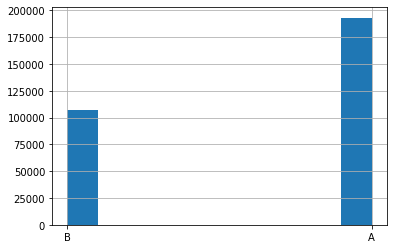

cat1


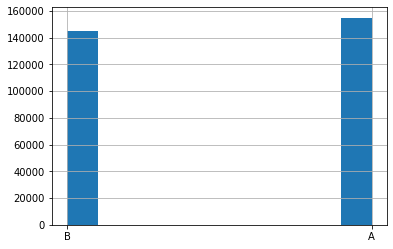

cat2


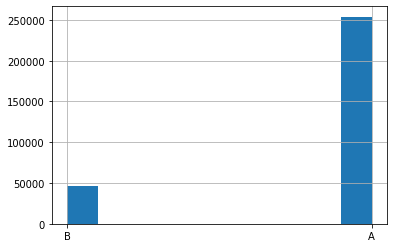

cat3


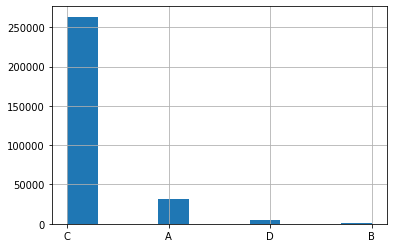

cat4


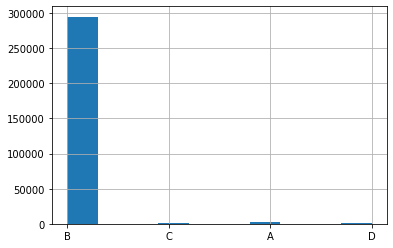

cat5


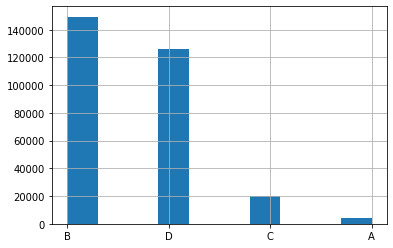

cat6


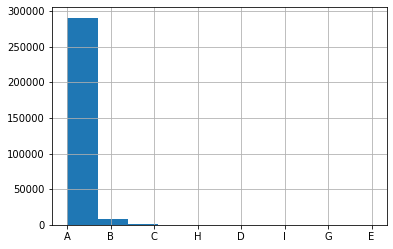

cat7


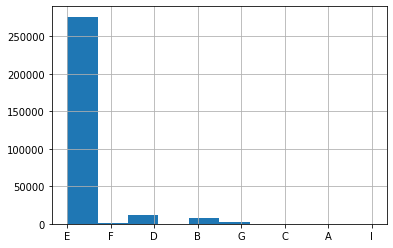

cat8


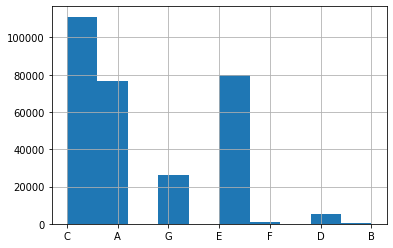

cat9


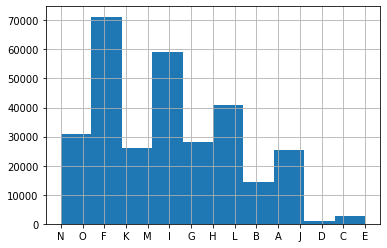

cont0


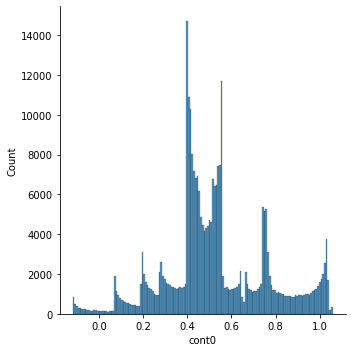

cont1


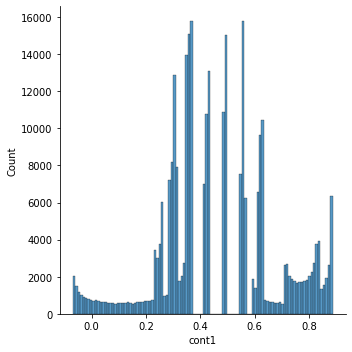

cont2


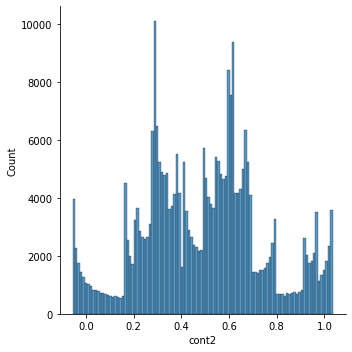

cont3


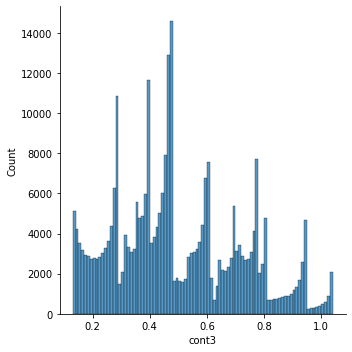

cont4


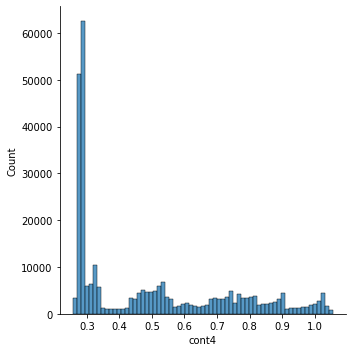

cont5


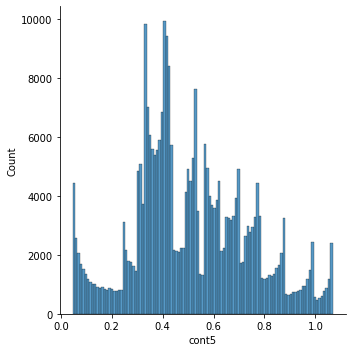

cont6


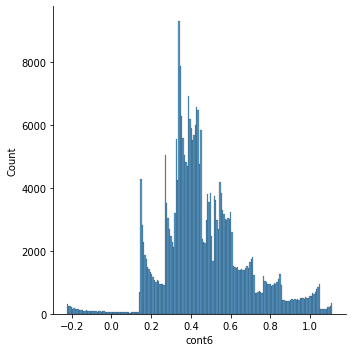

cont7


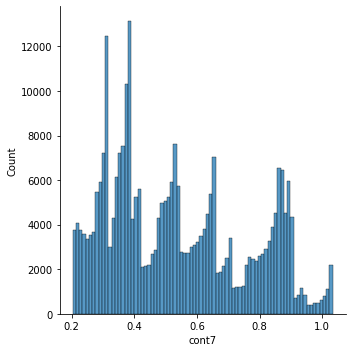

cont8


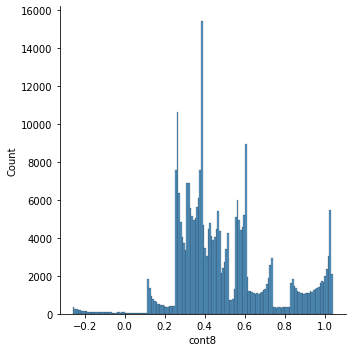

cont9


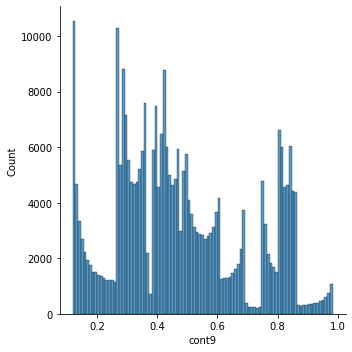

cont10


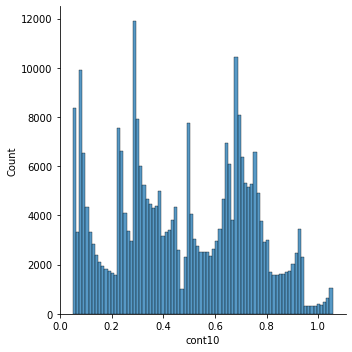

cont11


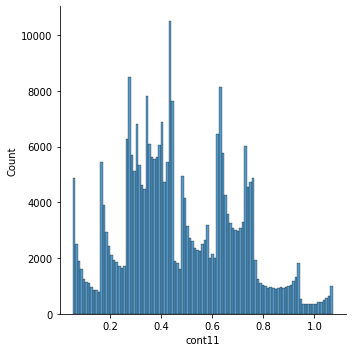

cont12


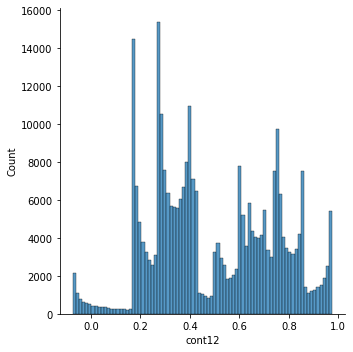

cont13


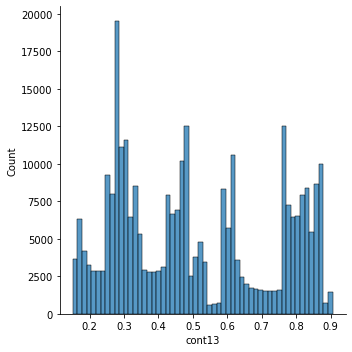

0         8.113634
1         8.481233
2         8.364351
3         8.049253
4         7.972260
            ...   
299995    7.945605
299996    7.326118
299997    8.706755
299998    7.229569
299999    8.631146
Name: target, Length: 300000, dtype: float64


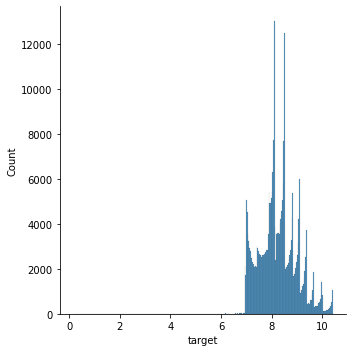

In [5]:
def plot():
    for i in range(10):
        #print(train_data[categorical_cols[i]])
        print(categorical_cols[i])
        train_data[categorical_cols[i]].hist()
        
        plt.show()
    #plt.subplot(1, 2, 1)
    
    for i in range(14):
        
        print(cont_cols[i])
        dataset = train_data[cont_cols[i]]
        seaborn.displot(data = dataset)
        plt.show()

    print(train_data.target)
    dataset = train_data.target
    seaborn.displot(data = dataset)
    plt.show()
plot()

In [52]:
train_data[categorical_cols]

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,B,B,B,C,B,B,A,E,C,N
1,B,B,A,A,B,D,A,F,A,O
2,A,A,A,C,B,D,A,D,A,F
3,B,B,A,C,B,D,A,E,C,K
4,A,A,A,C,B,D,A,E,A,N
...,...,...,...,...,...,...,...,...,...,...
299995,B,B,A,A,B,D,A,E,A,I
299996,A,B,A,C,B,B,A,E,E,F
299997,B,B,A,C,B,C,A,E,G,F
299998,A,B,A,C,B,B,A,E,E,I


In [49]:
skew_features_categorical = train_data[categorical_cols].skew().sort_values(ascending = False) 

In [50]:
skew_features_categorical

Series([], dtype: float64)

In [47]:
skew_features = train_data[cont_cols].skew().sort_values(ascending = False)

In [71]:
skew_features

cont4     0.776598
cont8     0.540071
cont6     0.507824
cont7     0.428809
cont3     0.402795
cont9     0.388129
cont11    0.318717
cont5     0.275822
cont13    0.243352
cont0     0.236360
cont12    0.101119
cont2     0.082866
cont10    0.056184
cont1     0.032677
dtype: float64

In [29]:
train_data[cont_cols]

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.697124,0.483452,0.297770,0.195821,0.307883,0.769792,0.450538,0.934360,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404
299996,0.446200,0.715135,0.610931,0.601730,0.736713,0.528056,0.508502,0.358247,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611
299997,0.544279,0.060937,0.590955,0.905308,0.277074,0.688747,0.372425,0.364936,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732
299998,0.300062,0.613118,0.285213,0.406851,0.805963,0.344404,0.424243,0.382028,0.468819,0.351036,0.288768,0.611169,0.380254,0.332030


In [7]:
list1 = [1, 2, 3, 4]
list2 = [2, 3, 10, 0]
list3 = list(zip(list1, list2))

In [8]:
list3

[(1, 2), (2, 3), (3, 10), (4, 0)]

In [15]:
[np.mean(i) for i in list3]

[1.5, 2.5, 6.5, 2.0]